# Assignment 9

Neural need huge amount of data to be able to perform well. Huge amount of data means huge computation power... To bypass the fact that we don't own this kind of machine, we will us the transfer leaning. By using a pretrained network (usually on ImageNet) and train it a little bit, we can avoid most of the computationnal power needed to perform our task. We will work on the ResNet network (https://arxiv.org/pdf/1512.03385.pdf) designed in 2014. 
Then, because we know you all have a degree in medicine, we will try our luck bu doing some! We will then retrain the last layer of the network to be able to recognize leopard and cheetah. The cheetah mini database is in the image folder.

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


plt.ion()   # interactive mode

In [2]:
data_dir = 'images/cheetah_data_mini'
TRAIN = 'train'
TEST = 'val'

# ResNet Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 450 images under train
Loaded 162 images under val
Classes: 
['cheetah', 'leopard', 'unknown']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 228, 906])
torch.Size([3, 228])


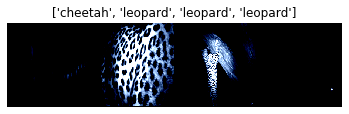

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    print(out.shape)
    print(out[:,:,15].shape)
    imshow(out, title=[class_names[x] for x in classes])


# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

## Pretrained network

Now load a network pre-trained on Imagenet and classify the validation data. You can import a pretrained model directly from pytorch with models.resnet18(pretrained=True). The labels are already used in ImageNet so try to recognize the database directly using the output of the pretrained network on the validation database.

In [6]:
# NET
model_vanilla = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/jimneuendorf/.cache/torch/checkpoints/resnet18-5c106cde.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)>

In [9]:
for param in model_vanilla.parameters():
    param.requires_grad = False

In [10]:
# cheetah = 293; leopard = 288;

In [11]:
# TEST THE NET ON OUR DATASET
def switch_class_idx(predicted):
    for x in range(predicted.shape[0]):
        if predicted[x] == 293:
            predicted[x] = 0
        elif predicted[x] == 288:
            predicted[x] = 1
        else:
            predicted[x] = 2
    return predicted

def val_pretrained(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders[TEST]:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            print(predicted)
            predicted = switch_class_idx(predicted)
            #print(labels, predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))

val_pretrained(model_vanilla)

tensor([494, 911, 361, 210])
tensor([998, 882, 539, 307])
tensor([587, 150, 494, 293])
tensor([749,  92, 758, 345])
tensor([164, 733, 835, 568])
tensor([178, 646, 758, 251])
tensor([497, 678, 462, 363])
tensor([293, 845, 696, 676])
tensor([541, 818, 463,  50])
tensor([764,  86, 541, 666])
tensor([728, 210, 595, 113])
tensor([866,  71, 710, 770])
tensor([ 87, 733,  26, 162])
tensor([ 94, 618, 845, 580])
tensor([409, 855, 456, 341])
tensor([618,  36, 184, 733])
tensor([552, 273, 708, 845])
tensor([805, 359, 733, 345])
tensor([171, 506, 988, 733])
tensor([464, 448, 172, 868])
tensor([276, 248, 522, 518])
tensor([728,  39, 490, 417])
tensor([515, 122, 616, 164])
tensor([845, 407, 452,  99])
tensor([583, 329, 356, 749])
tensor([852, 749, 494, 845])
tensor([494, 348, 674, 770])
tensor([329,  42, 556, 428])
tensor([876, 747, 772, 177])
tensor([845, 856, 695, 171])
tensor([731, 859, 695,  60])
tensor([855, 356, 830, 577])
tensor([625, 684, 749, 356])
tensor([464, 899, 733, 994])
tensor([778, 4

## Transfer learning

The pre-trained network can now be further trained with our data. Replace the last layer in the network with a fully connected Layer with 3 outputs for our classes cheetah, leopard and unknown. Then train the last layer of the network.

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        model.train()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[TRAIN]:
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            scheduler.step()

            epoch_loss = running_loss / dataset_sizes[TRAIN]
            epoch_acc = running_corrects.double() / dataset_sizes[TRAIN]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            "TRAIN", epoch_loss, epoch_acc))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

In [13]:
# FEATURE EXTRACTING
model_extract = torchvision.models.resnet18(pretrained=True)
for param in model_extract.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_extract.fc.in_features
model_extract.fc = nn.Linear(num_ftrs, 3)

criterion = nn.CrossEntropyLoss()
optimizer_ext = optim.SGD(model_extract.fc.parameters(), lr=.0001, momentum=0.9)

# Decay LR by a factor
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ext, step_size=5, gamma=0.1)

In [15]:
model_extract = train_model(model_extract, criterion, optimizer_ext,
                         exp_lr_scheduler, num_epochs=3)

Epoch 1/3
----------
TRAIN Loss: 1.2010 Acc: 0.3600

Epoch 2/3
----------
TRAIN Loss: 1.2009 Acc: 0.3267

Epoch 3/3
----------
TRAIN Loss: 1.2007 Acc: 0.3356

Training complete in 2m 28s


In [ ]:
def val_extract(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders[TEST]:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            #print(labels, predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy: %d %%' % (
        100 * correct / total))
    
val_extract(model_extract)